In [1]:
from os.path import join
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch

from src.model.get_model import get_multistep_linear_model
from src.env.MiniFurnace import MiniFurnace
from src.control.mpc import MPC
from src.utils.data_preprocessing import get_data

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# MPC with trained model

## MPC Hyperparameters

In [2]:
env = MiniFurnace()
observation_min = env.observation_space['low']
observation_max = env.observation_space['high']
action_min = env.action_space['low']
action_max = env.action_space['high']

model_name = 'multistep_linear_res2'

# Set your best model hyperparameter
state_order = 5
action_order = 20

receding_horizon = 7
max_iter = 400
is_logging = True
opt_config = {'lr': 1e-2}

## Prepare for MPC

In [3]:
state_dim = env.state_dim
action_dim = env.action_dim

saved_model_path = 'saved_model/{}/best_model_{}_{}.pt'.format(model_name, state_order, action_order)
m = get_multistep_linear_model(model_name, state_dim, action_dim, state_order, action_order, saved_model_path=saved_model_path).to(device)
m.eval()
mpc_solver = MPC(model=m,
                 action_dim=action_dim,
                 receding_horizon=receding_horizon,
                 action_min=action_min,
                 action_max=action_max,
                 gamma=env.gamma,
                 max_iter=max_iter,
                 is_logging=is_logging,
                 device=device,
                 opt_config=opt_config)

## load reference trajectory

In [4]:
y = np.transpose(np.load('data/reference_trajectory.npy'))
T = y.shape[0]  # Reference trajectory length

In [5]:
y.shape

(140, 5)

## Run MPC

In [6]:
observation_trajectory = []
action_trajectory = []
log_trajectory = []

past_observations, past_actions = env.reset()
past_observations, past_actions = past_observations[-state_order:, :], past_actions[-action_order: , :][1:]

for t in range(T - receding_horizon):
    print('Now [{}] / [{}]'.format(t, T - receding_horizon))
    optimal_actions, log = mpc_solver.solve(x0=past_observations, u0=past_actions, y=y[t:t + receding_horizon, :])
    action = optimal_actions[0, :].reshape(1, -1)  # proceed first action
    observation = env.step(action)

    observation_trajectory.append(observation)
    action_trajectory.append(action)
    log_trajectory.append(log)

    past_observations = np.concatenate((past_observations, observation), axis=0)[1:]
    past_actions = np.concatenate((past_actions, action), axis=0)[1:]

observation_trajectory = np.concatenate(observation_trajectory, axis=0)
action_trajectory = np.concatenate(action_trajectory, axis=0)

mpc_result = {
    'traj_obs': observation_trajectory,
    'traj_action': action_trajectory,
    'log': log_trajectory
}
with open('mpc_result/result.log', 'wb') as f:
    pickle.dump(mpc_result, f)


Now [0] / [133]
Now [1] / [133]
Now [2] / [133]
Now [3] / [133]
Now [4] / [133]
Now [5] / [133]
Now [6] / [133]
Now [7] / [133]
Now [8] / [133]
Now [9] / [133]
Now [10] / [133]
Now [11] / [133]
Now [12] / [133]
Now [13] / [133]
Now [14] / [133]
Now [15] / [133]
Now [16] / [133]
Now [17] / [133]
Now [18] / [133]
Now [19] / [133]
Now [20] / [133]
Now [21] / [133]
Now [22] / [133]
Now [23] / [133]
Now [24] / [133]
Now [25] / [133]
Now [26] / [133]
Now [27] / [133]
Now [28] / [133]
Now [29] / [133]
Now [30] / [133]
Now [31] / [133]
Now [32] / [133]
Now [33] / [133]
Now [34] / [133]
Now [35] / [133]
Now [36] / [133]
Now [37] / [133]
Now [38] / [133]
Now [39] / [133]
Now [40] / [133]
Now [41] / [133]
Now [42] / [133]
Now [43] / [133]
Now [44] / [133]
Now [45] / [133]
Now [46] / [133]
Now [47] / [133]
Now [48] / [133]
Now [49] / [133]
Now [50] / [133]
Now [51] / [133]
Now [52] / [133]
Now [53] / [133]
Now [54] / [133]
Now [55] / [133]
Now [56] / [133]
Now [57] / [133]
Now [58] / [133]
Now [59

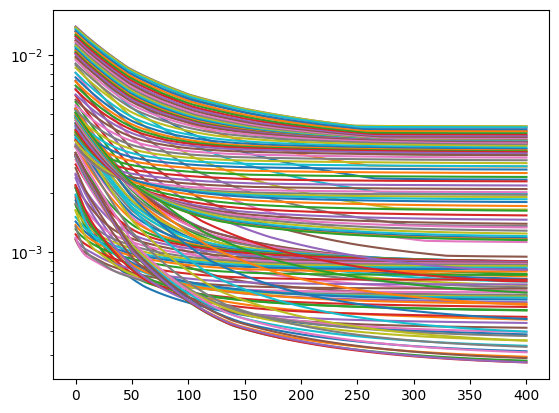

In [7]:
for i in range(len(log_trajectory)):
    plt.plot(log_trajectory[i]['loss'])
    plt.yscale('log')

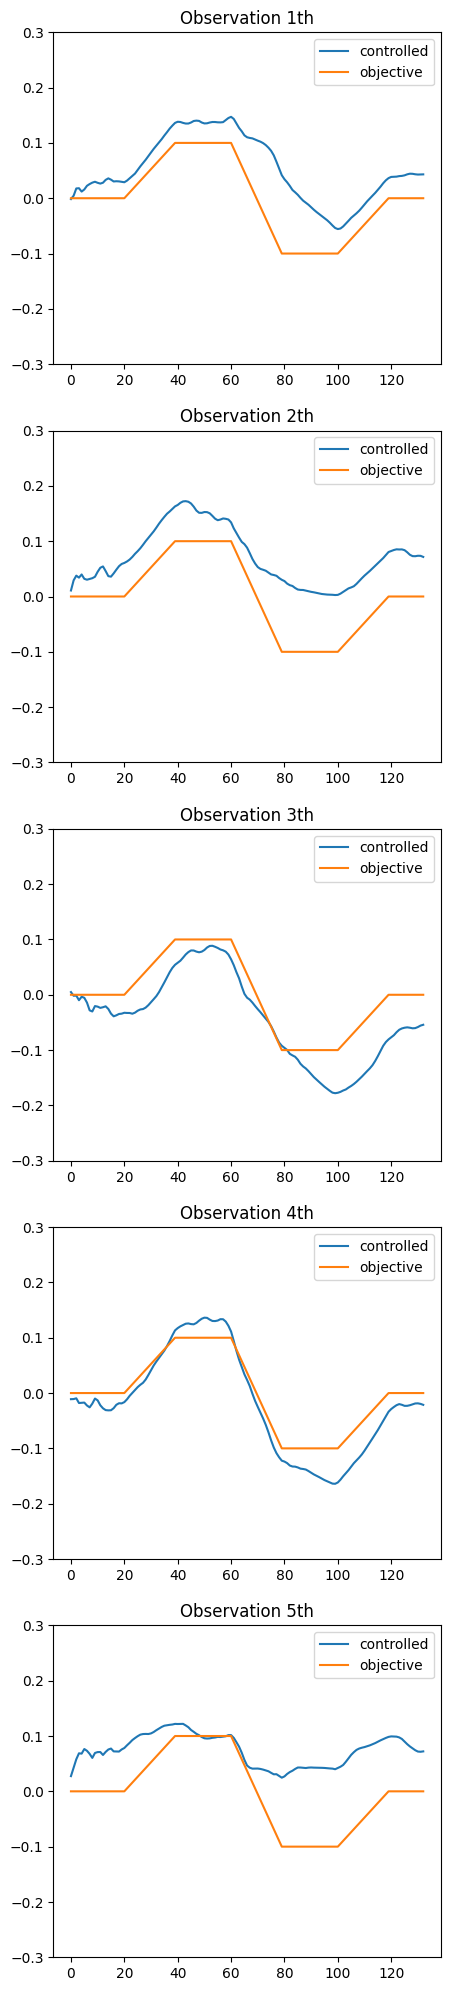

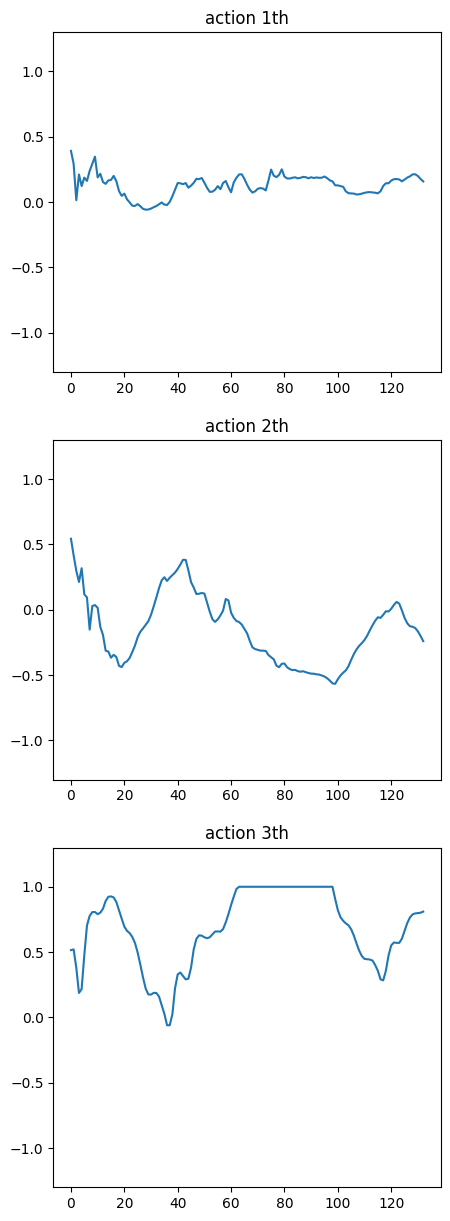

In [8]:
fig, axes = plt.subplots(5, 1, figsize=(5, 25))
axes_flatten = axes.flatten()
for i in range(len(axes_flatten)):
    axes_flatten[i].plot(observation_trajectory[:, i], label='controlled')
    axes_flatten[i].plot(y[:-receding_horizon, i], label='objective')
    axes_flatten[i].legend()
    
    axes_flatten[i].set_ylim([-0.3, 0.3])
    axes_flatten[i].set_title('Observation {}th'.format(i+1))

fig, axes = plt.subplots(3, 1, figsize=(5, 15))
axes_flatten = axes.flatten()
for i in range(len(axes_flatten)):
    axes_flatten[i].plot(action_trajectory[:, i])
    axes_flatten[i].set_ylim([-1.3, 1.3])
    axes_flatten[i].set_title('action {}th'.format(i+1))

# MPC with real model

In [11]:
initial_obs, initial_actions = env.reset()

In [12]:
initial_obs, initial_actions = env.reset()
fake_action = np.ones((1, 3))
env_state = env.step(fake_action)

## Copy env's parameter

In [25]:
tensor_A = torch.from_numpy(env.A).float()  # state_order * state_dim * state_dim 
tensor_B = torch.from_numpy(env.B).float()  # action_order * action_dim * state_dim
tensor_C = torch.from_numpy(env.C).float()  # state_dim

true_state_order = 5
true_action_order = 10
m_real = get_multistep_linear_model(model_name, state_dim, action_dim, true_state_order, true_action_order).to(device)
m_real.A.data = tensor_A
m_real.B.data = tensor_B
m_real.C.data = tensor_C.view(1, -1)
m_real.A.data[-1] = m_real.A.data[-1] - torch.eye(state_dim)

In [27]:
# check model's parameter
model_state = m_real.multi_step_prediction(x0 = torch.zeros(true_state_order, state_dim), u0=torch.zeros(true_action_order-1, action_dim), us=torch.ones(1, action_dim))
print(env_state, model_state)

[[ 0.00201068 -0.00012225 -0.00352202 -0.03483959  0.034771  ]] tensor([[ 0.0020, -0.0001, -0.0035, -0.0348,  0.0348]],
       grad_fn=<SqueezeBackward1>)


In [28]:
m_real.eval()
mpc_solver_real = MPC(model=m_real,
                 action_dim=action_dim,
                 receding_horizon=receding_horizon,
                 action_min=action_min,
                 action_max=action_max,
                 gamma=env.gamma,
                 max_iter=max_iter,
                 is_logging=is_logging,
                 device=device,
                 opt_config=opt_config)

In [ ]:
observation_trajectory = []
action_trajectory = []
log_trajectory = []

past_observations, past_actions = env.reset()
past_observations, past_actions = past_observations[-true_state_order:, :], past_actions[-true_action_order: , :][1:]

for t in range(T - receding_horizon):
    print('Now [{}] / [{}]'.format(t, T - receding_horizon))
    optimal_actions, log = mpc_solver_real.solve(x0=past_observations, u0=past_actions, y=y[t:t + receding_horizon, :])
    action = optimal_actions[0, :].reshape(1, -1)  # * (action_max - action_min) + action_min
    observation = env.step(action)

    observation_trajectory.append(observation)
    action_trajectory.append(action)
    log_trajectory.append(log)

    past_observations = np.concatenate((past_observations, observation), axis=0)[1:]
    past_actions = np.concatenate((past_actions, action), axis=0)[1:]

observation_trajectory = np.concatenate(observation_trajectory, axis=0)
action_trajectory = np.concatenate(action_trajectory, axis=0)

mpc_result = {
    'traj_obs': observation_trajectory,
    'traj_action': action_trajectory,
    'log': log_trajectory
}
with open('mpc_result/result.log', 'wb') as f:
    pickle.dump(mpc_result, f)


Now [0] / [133]
Now [1] / [133]
Now [2] / [133]
Now [3] / [133]
Now [4] / [133]
Now [5] / [133]
Now [6] / [133]
Now [7] / [133]
Now [8] / [133]
Now [9] / [133]
Now [10] / [133]
Now [11] / [133]
Now [12] / [133]
Now [13] / [133]
Now [14] / [133]
Now [15] / [133]
Now [16] / [133]
Now [17] / [133]
Now [18] / [133]
Now [19] / [133]
Now [20] / [133]
Now [21] / [133]
Now [22] / [133]
Now [23] / [133]
Now [24] / [133]
Now [25] / [133]
Now [26] / [133]
Now [27] / [133]
Now [28] / [133]
Now [29] / [133]
Now [30] / [133]
Now [31] / [133]
Now [32] / [133]
Now [33] / [133]
Now [34] / [133]
Now [35] / [133]
Now [36] / [133]
Now [37] / [133]
Now [38] / [133]
Now [39] / [133]
Now [40] / [133]
Now [41] / [133]
Now [42] / [133]
Now [43] / [133]
Now [44] / [133]
Now [45] / [133]
Now [46] / [133]
Now [47] / [133]
Now [48] / [133]
Now [49] / [133]
Now [50] / [133]
Now [51] / [133]
Now [52] / [133]
Now [53] / [133]
Now [54] / [133]
Now [55] / [133]
Now [56] / [133]
Now [57] / [133]
Now [58] / [133]
Now [59

In [ ]:
for i in range(len(log_trajectory)):
    plt.plot(log_trajectory[i]['loss'])
    plt.yscale('log')

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(5, 25))
axes_flatten = axes.flatten()
for i in range(len(axes_flatten)):
    axes_flatten[i].plot(observation_trajectory[:, i], label='controlled')
    axes_flatten[i].plot(y[:-receding_horizon, i], label='objective')
    axes_flatten[i].legend()
    
    axes_flatten[i].set_ylim([-0.3, 0.3])
    axes_flatten[i].set_title('Observation {}th'.format(i+1))

fig, axes = plt.subplots(3, 1, figsize=(5, 15))
axes_flatten = axes.flatten()
for i in range(len(axes_flatten)):
    axes_flatten[i].plot(action_trajectory[:, i])
    axes_flatten[i].set_ylim([-1.3, 1.3])
    axes_flatten[i].set_title('action {}th'.format(i+1))